In [15]:
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import numpy as np

p = 'C:/Users/15714/Documents/homework/2022 Fall/DAEN 690/Project Docs/data_providers/tagged_data_28-11-2022_21_08_44.csv'
df = pd.read_csv(p).drop('Unnamed: 0', axis =1)
extd_df = pd.read_csv('../data/EXPANDED_acled_covid19.csv')
df[df['country'].notnull()]

,source_singular,country,country_pct,country_total,sub_event_type,sub_event_type_pct,sub_event_type_total
10,Diario Co Latino,El_Salvador_majority,1.0,10.0,Peaceful_protest_majority,0.800000,8.0
11,El Salvador.com,El_Salvador_majority,1.0,16.0,Peaceful_protest_majority,0.875000,14.0
15,Brescia Today,Italy_majority,1.0,14.0,Peaceful_protest_majority,0.857143,12.0
25,AM New York,United_States_majority,1.0,46.0,Peaceful_protest_majority,0.956522,44.0
29,Leipziger Volkszeitung,Germany_majority,1.0,28.0,Peaceful_protest_majority,1.000000,28.0
...,...,...,...,...,...,...,...
5180,Zimbabwe Human Rights NGO Forum,Zimbabwe_majority,1.0,7.0,Attack_majority,0.857143,6.0
5313,Antimafia Duemila,Italy_majority,1.0,5.0,Violent_demonstration_majority,0.800000,4.0
5331,Assistance Association for Political Prisoners,Myanmar_majority,1.0,5.0,Attack_majority,0.800000,4.0
5342,Bild Ostergotland,Sweden_majority,1.0,13.0,Peaceful_protest_majority,1.000000,13.0


In [41]:
# sqldf('''
#     SELECT count(distinct source_singular)
#     FROM df
# ''', globals())

sqldf('''
    SELECT count(DISTINCT source_singular)
    FROM df
''', globals())

,count(DISTINCT source_singular)
0,5366


In [25]:
def _clean(c):
    for r in [' ', '-', '/']:
        c = c.replace(r, '_')
    
    for r in ['.', ',']:
        c = c.replace(r, '')
    
    return c

cty = sqldf('''
    SELECT DISTINCT source_singular, country
    FROM df
    WHERE country IS NOT NULL
''', globals())

cty['country'] = cty['country'].str.replace('_majority','')
cty['country_cln'] = [_clean(c) for c in cty['country']]

evt = sqldf('''
    SELECT DISTINCT source_singular, sub_event_type
    FROM df
    WHERE sub_event_type IS NOT NULL
''', globals())

evt['sub_event_type'] = evt['sub_event_type'].str.replace('_majority','')
evt['sub_event_type_cln'] = [_clean(c) for c in evt['sub_event_type']]

In [26]:
cty_notin = [c for c in list(set(extd_df['country'])) if c not in list(cty['country_cln'])]
len(cty_notin)

126

In [36]:
evt_notin = [c for c in list(set(extd_df['sub_event_type'])) if _clean(c) not in list(evt['sub_event_type_cln'])]
len(evt_notin)

9

In [32]:
print(set(df['sub_event_type']))
print('-' * 40)
print(list(set(evt['sub_event_type_cln'])))

{'Attack_majority', 'Peaceful_protest_majority', 'Mob_violence_majority', 'Looting_property_destruction_majority', 'Violent_demonstration_majority', 'Agreement_majority', 'Protest_with_intervention_majority', nan, 'Excessive_force_against_protesters_majority', 'Other_majority', 'Change_to_group_activity_majority'}
----------------------------------------
['Attack', 'Change_to_group_activity', 'Mob_violence', 'Excessive_force_against_protesters', 'Other', 'Protest_with_intervention', 'Agreement', 'Looting_property_destruction', 'Peaceful_protest', 'Violent_demonstration']


<AxesSubplot:title={'center':'Tag Value Percent Threshold vs. Total Unique Countries Tagged'}, xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Countries'>

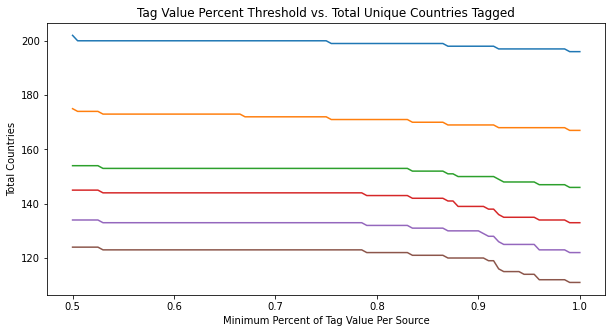

In [118]:
cnt_df = sqldf('''
    SELECT a.source_singular, a.country, cnt, cast(total as int) total, cast(cast(cnt as double)/cast(total as double) as double) pct FROM
        (SELECT source_singular, country, count(*) cnt FROM extd_df GROUP BY source_singular, country) a
        JOIN (SELECT source_singular, count(*) total FROM extd_df GROUP BY source_singular) b
        ON a.source_singular = b.source_singular
''', globals())

def _newdf(cnt_min):
    pcts = np.linspace(0.5,1,101)
    newdf = pd.DataFrame()

    newdf['pcts'] = pcts
    cond = (cnt_df['total'] > cnt_min)
    newdf['cnt'] = [len(list(set(cnt_df[(cnt_df['pct'] >= p) & cond]['country']))) for p in pcts]
    
    return newdf


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Tag Value Percent Threshold vs. Total Unique Countries Tagged')
ax.set(xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Countries')

df0 = _newdf(0)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)

df2 = _newdf(2)
sns.lineplot(data=df2, x=df2['pcts'], y=df2['cnt'], ax=ax)

df4 = _newdf(4)
sns.lineplot(data=df4, x=df4['pcts'], y=df4['cnt'], ax=ax)

df6 = _newdf(6)
sns.lineplot(data=df6, x=df6['pcts'], y=df6['cnt'], ax=ax)

df8 = _newdf(8)
sns.lineplot(data=df8, x=df8['pcts'], y=df8['cnt'], ax=ax)

df10 = _newdf(10)
sns.lineplot(data=df10, x=df10['pcts'], y=df10['cnt'], ax=ax)

<AxesSubplot:title={'center':'Tag Value Percent Threshold vs. Total Unique Event Types Tagged'}, xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Event Types'>

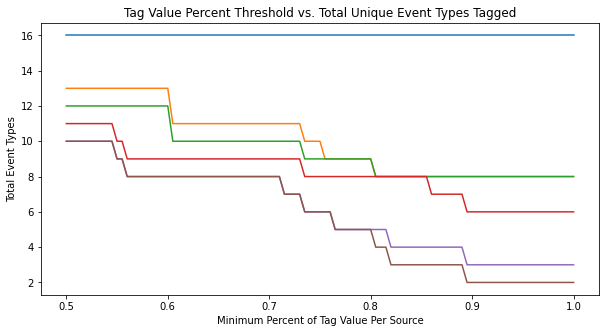

In [117]:
cnt_df = sqldf('''
    SELECT a.source_singular, a.sub_event_type, cnt, cast(total as int) total, cast(cast(cnt as double)/cast(total as double) as double) pct FROM
        (SELECT source_singular, sub_event_type, count(*) cnt FROM extd_df GROUP BY source_singular, sub_event_type) a
        JOIN (SELECT source_singular, count(*) total FROM extd_df GROUP BY source_singular) b
        ON a.source_singular = b.source_singular
''', globals())

def _newdf(cnt_min):
    pcts = np.linspace(0.5,1,101)
    newdf = pd.DataFrame()

    newdf['pcts'] = pcts
    cond = (cnt_df['total'] > cnt_min)
    newdf['cnt'] = [len(list(set(cnt_df[(cnt_df['pct'] >= p) & cond]['sub_event_type']))) for p in pcts]
    
    return newdf


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Tag Value Percent Threshold vs. Total Unique Event Types Tagged')
ax.set(xlabel='Minimum Percent of Tag Value Per Source', ylabel='Total Event Types')

df0 = _newdf(0)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)

df2 = _newdf(2)
sns.lineplot(data=df2, x=df2['pcts'], y=df2['cnt'], ax=ax)

df4 = _newdf(4)
sns.lineplot(data=df4, x=df4['pcts'], y=df4['cnt'], ax=ax)

df6 = _newdf(6)
sns.lineplot(data=df6, x=df6['pcts'], y=df6['cnt'], ax=ax)

df8 = _newdf(8)
sns.lineplot(data=df8, x=df8['pcts'], y=df8['cnt'], ax=ax)

df0 = _newdf(10)
sns.lineplot(data=df0, x=df0['pcts'], y=df0['cnt'], ax=ax)